# Drum sequencer VAE evaluation

In [1]:
%reload_ext autoreload

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_loglevel("info")

import seaborn as sns
sns.set_theme(style="whitegrid")

In [20]:
from collections import OrderedDict
from datetime import datetime
from google.cloud import storage
from itertools import islice
import math
import numpy as np
import os
from pathlib import Path
import torch
import time
from tqdm import tqdm
import wandb
import yaml

from dsvae.data.loader import NoteSequenceDataLoader
from dsvae.models.vae import VAE
from dsvae.utils.hparams import HParams

## Setup

Interesting runs:
- floral-lake-193
- elated-serenity-195

In [9]:
# env
os.environ["DEBUG"] = "1"
RUN_PATH = "mxkrn/drum-sequencer-vae-dsvae/1hj953io"
RUN_NAME = "elated-serenity-195"
DEVICE = "cuda:0"

BATCH_SIZE = 1

### Load data

In [10]:
path_to_data = Path(os.environ["DATA_SOURCE_DIR"])
data_loader = NoteSequenceDataLoader(
    path_to_data=path_to_data,
    batch_size=BATCH_SIZE,
    split="test",
    file_shuffle=True,
    pattern_shuffle=False,
    scale_factor=1,
    num_workers=0
)
input, target, fname, frame_index = next(iter(data_loader))

### Load model

In [15]:
# get hyperparameters
config = yaml.load(wandb.restore(f'config.yaml', run_path=RUN_PATH), Loader=yaml.FullLoader)
hparams = {}
for k, v in config.items():
    if not k in ['_wandb', 'wandb_version']:
        if isinstance(v, dict):
            hparams[k] = v["value"]
hparams = HParams(hparams)
# hparams.n_layers = 4
# hparams.hidden_factor = 2*hparams.hidden_factor

# get model
_state_dict_io = wandb.restore(f'outputs/models/{RUN_NAME}/latest.pt', run_path=RUN_PATH)
model = VAE(hparams, data_loader.channels)
model.load_state_dict(torch.load(_state_dict_io.name))
model = model.to(DEVICE)
model.eval()

VAE(
  (encoder): LSTMEncoder(
    (lstm): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.25)
  )
  (mu): Linear(in_features=4096, out_features=4, bias=True)
  (logvar): Linear(in_features=4096, out_features=4, bias=True)
  (from_latent): Linear(in_features=4, out_features=4096, bias=True)
  (note_dropout): NoteDropout()
  (decoder): LSTMDecoder(
    (lstm): LSTM(27, 512, num_layers=4, batch_first=True, dropout=0.25)
    (output_layer): Linear(in_features=512, out_features=27, bias=True)
  )
  (onsets_act): Sigmoid()
  (velocities_act): Sigmoid()
  (offsets_act): Tanh()
)

## Evaluation

We want to evaluate on several custom metrics:
1. Missing notes
2. Added notes

We will evaluate these metrics in several different scenarios, we expect specific results for each scenario.

### Teacher force ratio

In this panel, we analyze what happens when we use different teacher force ratios.

In [16]:
def get_onsets(tensor) -> torch.Tensor:
    onsets = torch.where(tensor[:, :, :9] >= threshold, 1., 0.)
    return onsets

def preprocess(pattern):
    pattern = torch.transpose(pattern, 1, 2)
    pattern = torch.flip(pattern, [0, 1])
    return pattern[0].cpu().numpy()

def normalize(pattern):
    max = np.max(pattern)
    return np.divide(pattern, torch.full(pattern.shape, max))

#### Run

In [22]:
output_data = OrderedDict()
teacher_force_ratios = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
data = [x for x in data_loader]
num_data_points = len(data)

# num_data_points = 10

for ratio in teacher_force_ratios:
    output_data[ratio] = {}
    output_data[ratio]["input_onsets"] = []
    output_data[ratio]["output_onsets"] = []
    print(f"------------------------ RATIO = {ratio} ------------------------")
    # define variables
    delta_z = torch.zeros(
        (BATCH_SIZE, hparams.latent_size), dtype=torch.float, device=DEVICE
    )
    teacher_force_ratio = torch.tensor(ratio, dtype=torch.float, device=DEVICE)
    threshold = 0.5

    missing_notes = []
    added_notes = []
    count = 0

    for input, target, fname, frame_index in tqdm(data):
        input = input.to(DEVICE, non_blocking=True)
        output, z, z_loss = model(input, delta_z, teacher_force_ratio)
    
        # get onsets
        output_onsets = get_onsets(output)
        input_onsets = get_onsets(input)
        delta = torch.ne(output_onsets, input_onsets).int()
        
        # append to example osnets
        if len(output_data[ratio]["input_onsets"]) < 4:
            output_data[ratio]["input_onsets"].append(preprocess(input_onsets))
        if len(output_data[ratio]["output_onsets"]) < 4:
            output_data[ratio]["output_onsets"].append(preprocess(output_onsets))
        
        # get missing notes
        missing = torch.mul(delta, input_onsets)
        missing_notes.append(torch.sum(missing).item())
        
        # get added notes
        added = torch.mul(delta, output_onsets)
        added_notes.append(torch.sum(added).item())
        
        if count == 0:
            total_added = added
            total_missing = missing
            count += 1
        else:
            total_added = torch.add(total_added, added)
            total_missing = torch.add(total_missing, missing)
    
    output_data[ratio]["total_added"] = total_added.view(-1, total_added.shape[1]*total_added.shape[2])
    output_data[ratio]["total_missing"] = total_missing.view(-1, total_missing.shape[1]*total_missing.shape[2])
    heatmap_added = preprocess(total_added)
    output_data[ratio]["heatmap_added"] = normalize(heatmap_added)
    heatmap_missing = preprocess(total_missing)
    output_data[ratio]["heatmap_missing"] = normalize(heatmap_missing)

  0%|          | 2/2575 [00:00<02:34, 16.60it/s]

------------------------ RATIO = 1.0 ------------------------


  0%|          | 2/2575 [00:00<02:56, 14.58it/s]

------------------------ RATIO = 0.8 ------------------------


  0%|          | 2/2575 [00:00<04:00, 10.69it/s]

------------------------ RATIO = 0.6 ------------------------


  0%|          | 1/2575 [00:00<06:23,  6.70it/s]

------------------------ RATIO = 0.4 ------------------------


  0%|          | 2/2575 [00:00<02:46, 15.44it/s]

------------------------ RATIO = 0.2 ------------------------


  0%|          | 1/2575 [00:00<06:12,  6.90it/s]

------------------------ RATIO = 0.0 ------------------------


100%|██████████| 2575/2575 [09:13<00:00,  4.65it/s]  


#### Examples

In [28]:
def plot_pattern_pair(input, output):
    fig, axs = plt.subplots(1, 2, figsize=(25, 3))
    axs[0].set_title("Input pattern")
    sns.heatmap(input, ax=axs[0])
    axs[1].set_title("Output pattern")
    sns.heatmap(output, ax=axs[1])
    plt.show()

------------------ RATIO = 1.0 ------------------



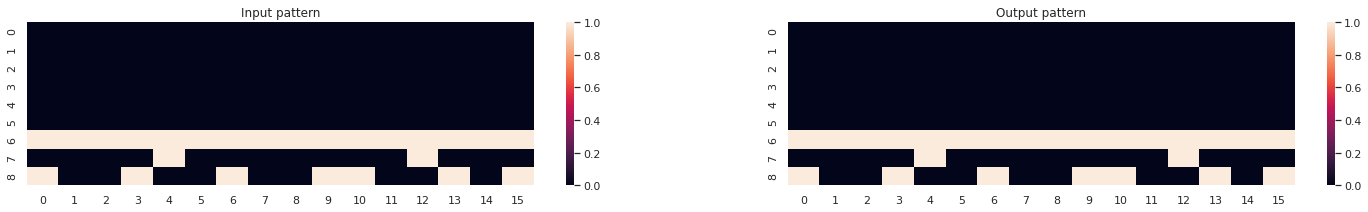

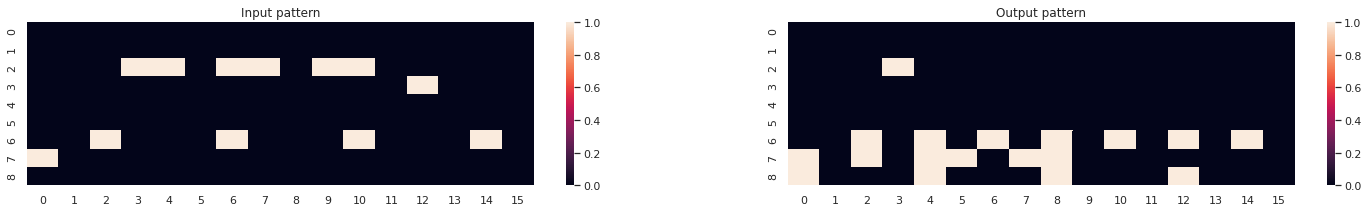

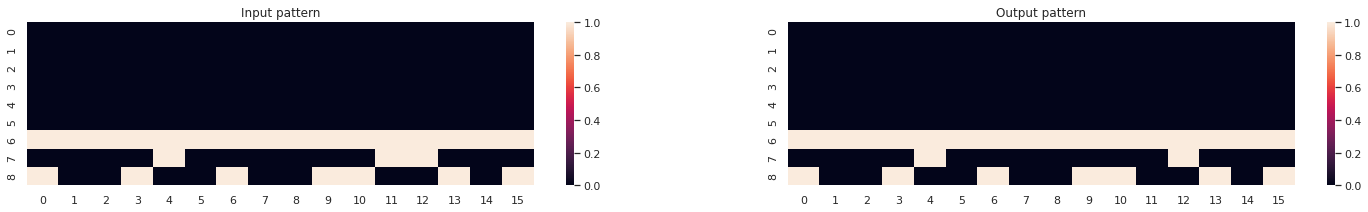

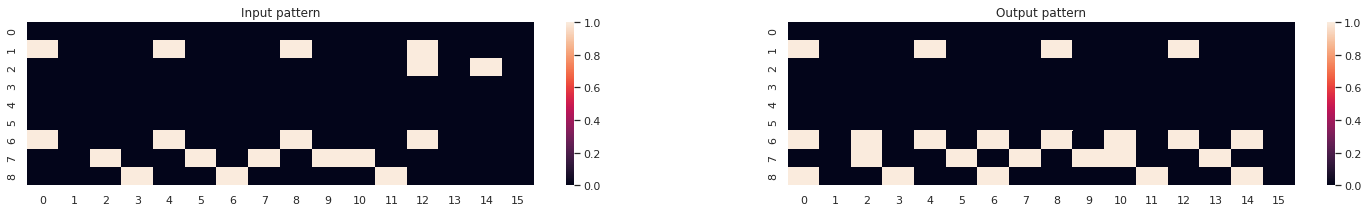

------------------ RATIO = 0.8 ------------------



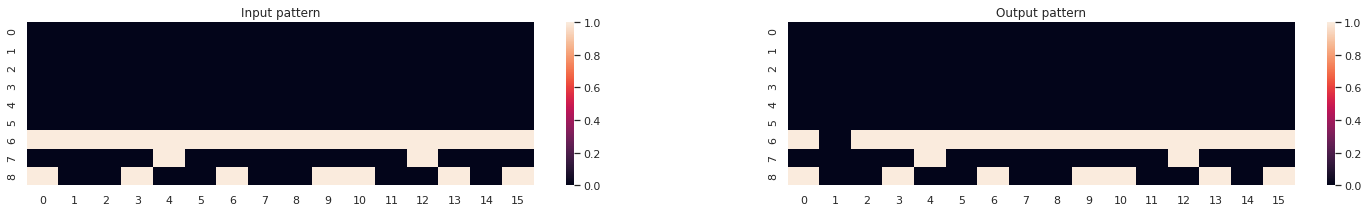

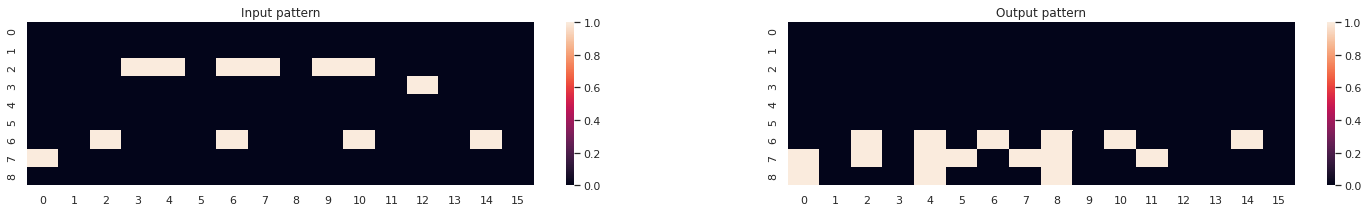

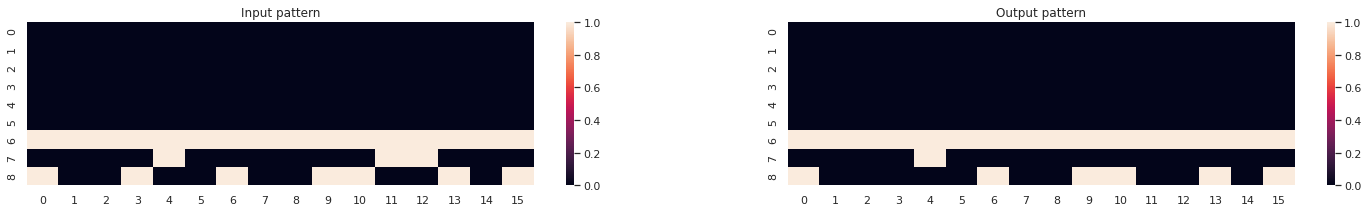

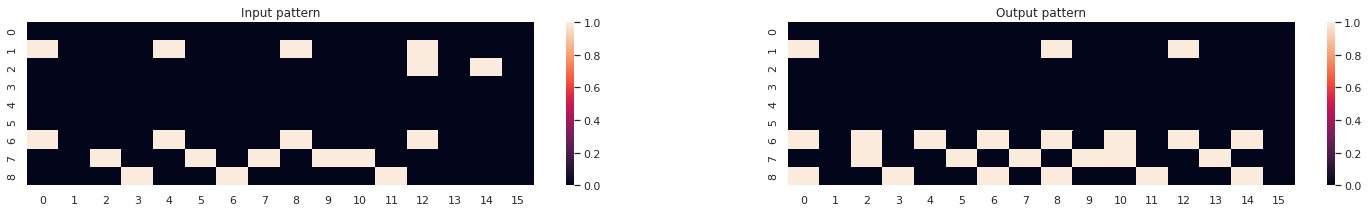

------------------ RATIO = 0.6 ------------------



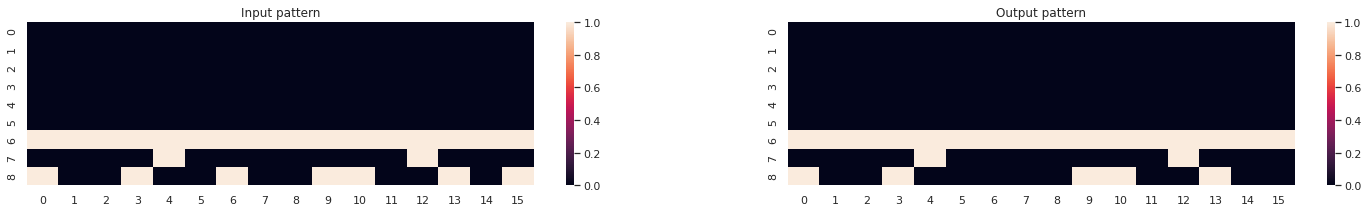

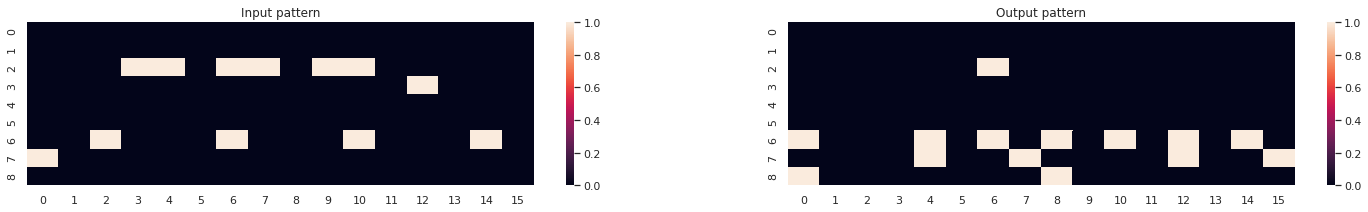

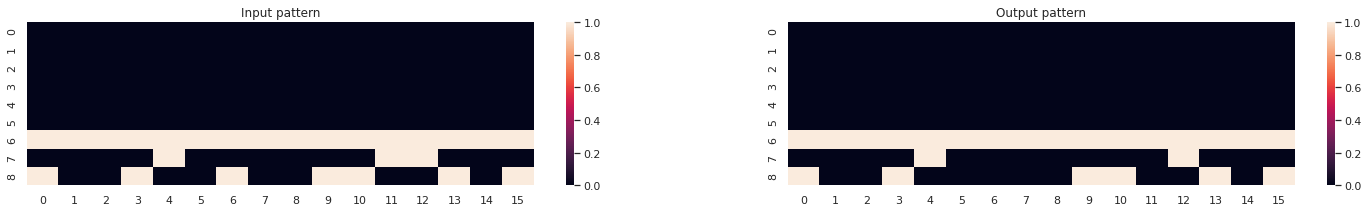

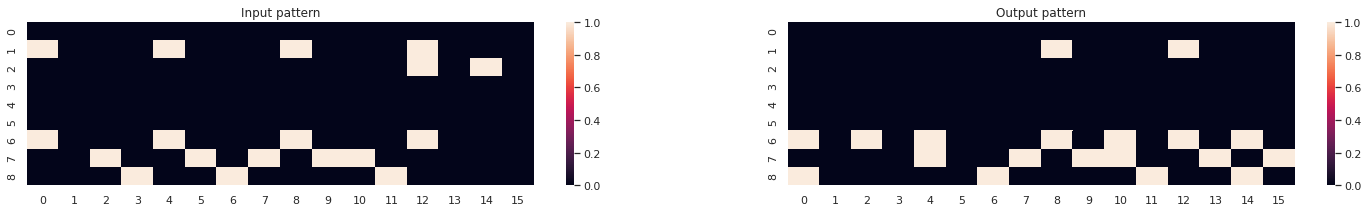

------------------ RATIO = 0.4 ------------------



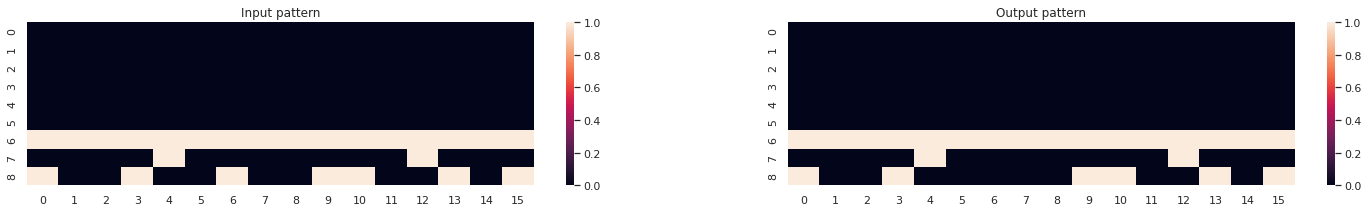

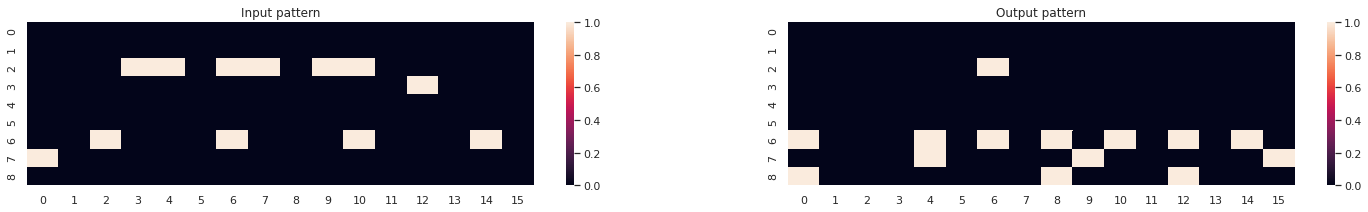

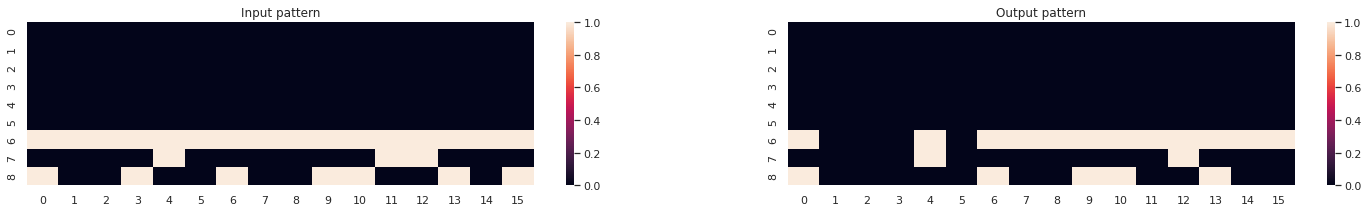

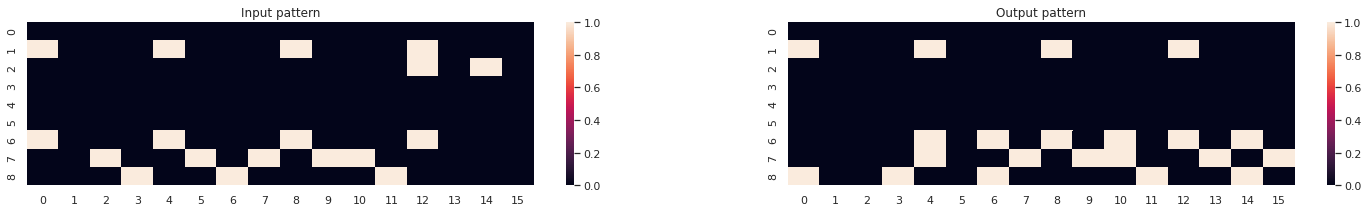

------------------ RATIO = 0.2 ------------------



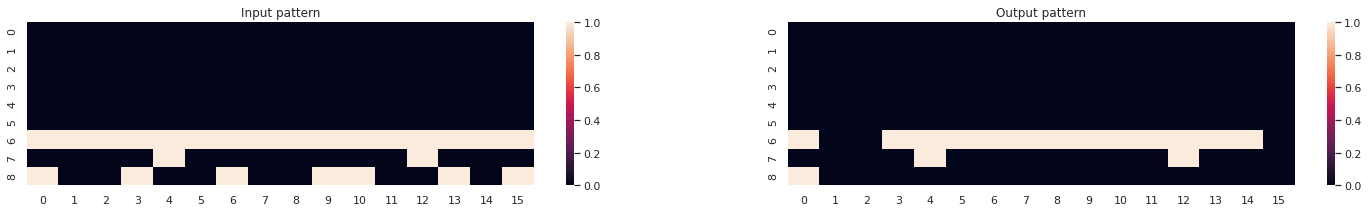

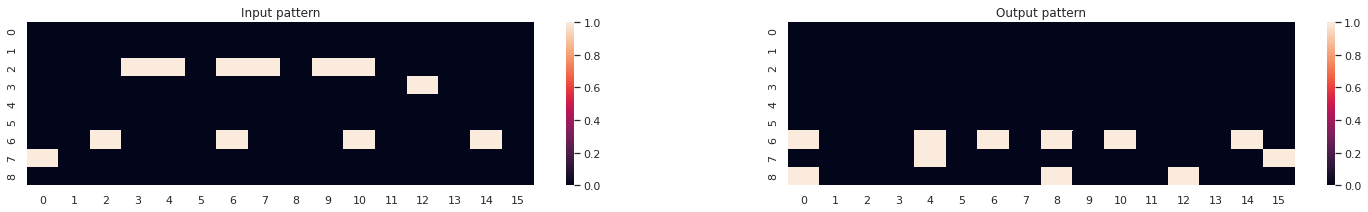

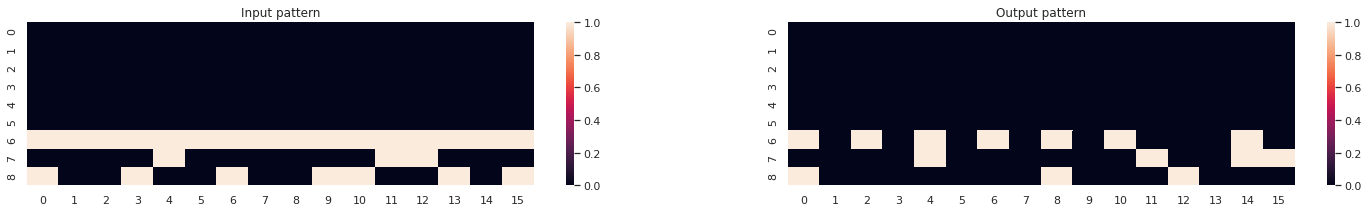

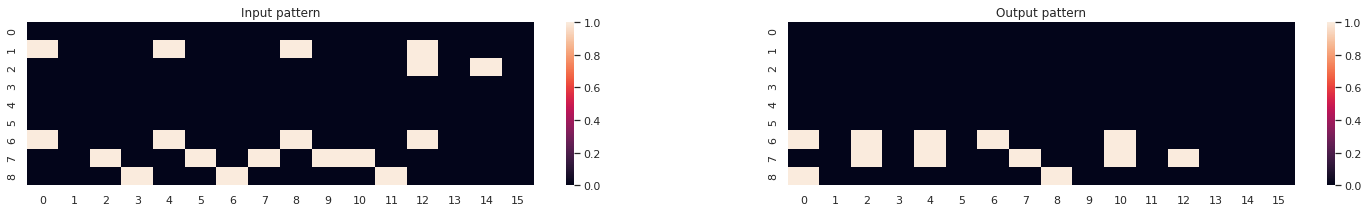

------------------ RATIO = 0.0 ------------------



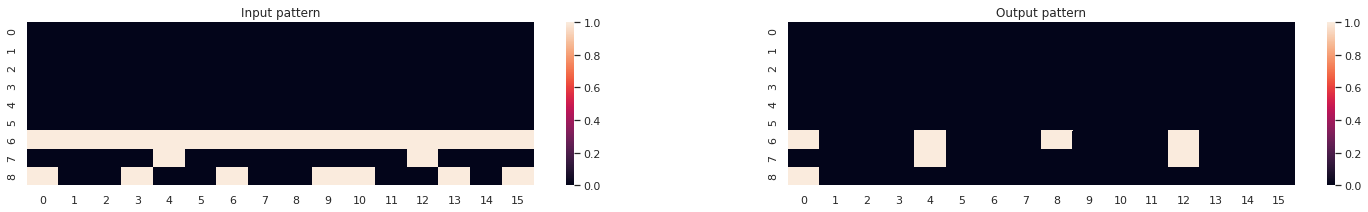

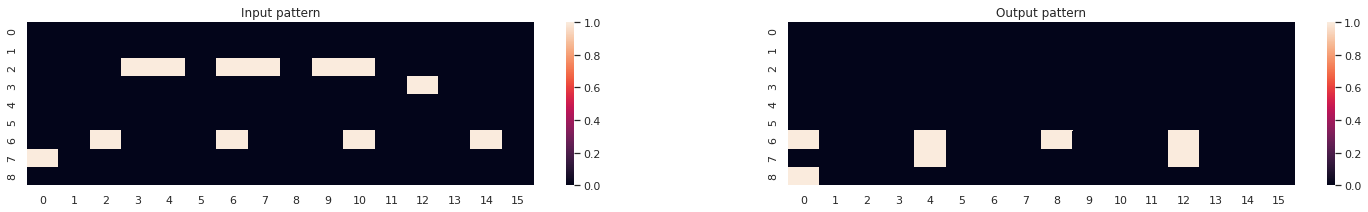

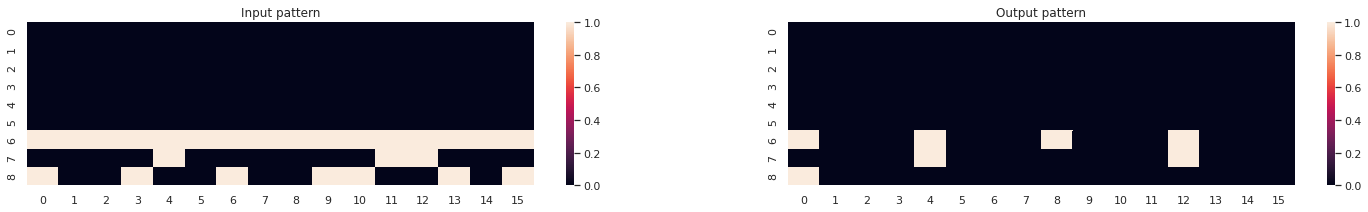

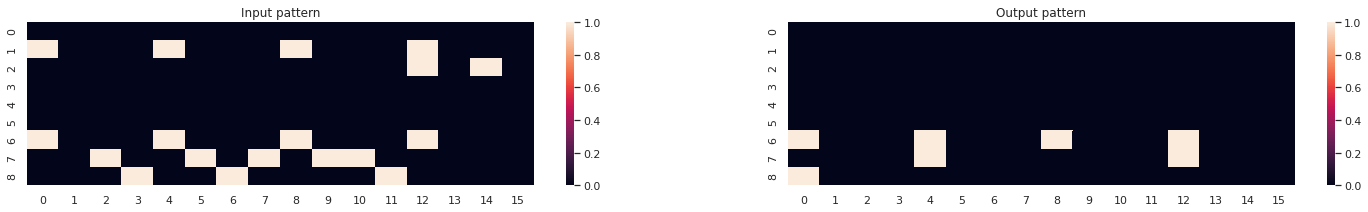

In [29]:
for ratio in teacher_force_ratios:
    print(f"------------------ RATIO = {ratio} ------------------\n")
    input_onsets = output_data[ratio]["input_onsets"]
    output_onsets = output_data[ratio]["output_onsets"]
    
    for i, onset in enumerate(input_onsets):
        plot_pattern_pair(onset, output_onsets[i])
        continue

#### Added notes

------------------------ ADDED NOTES ------------------------



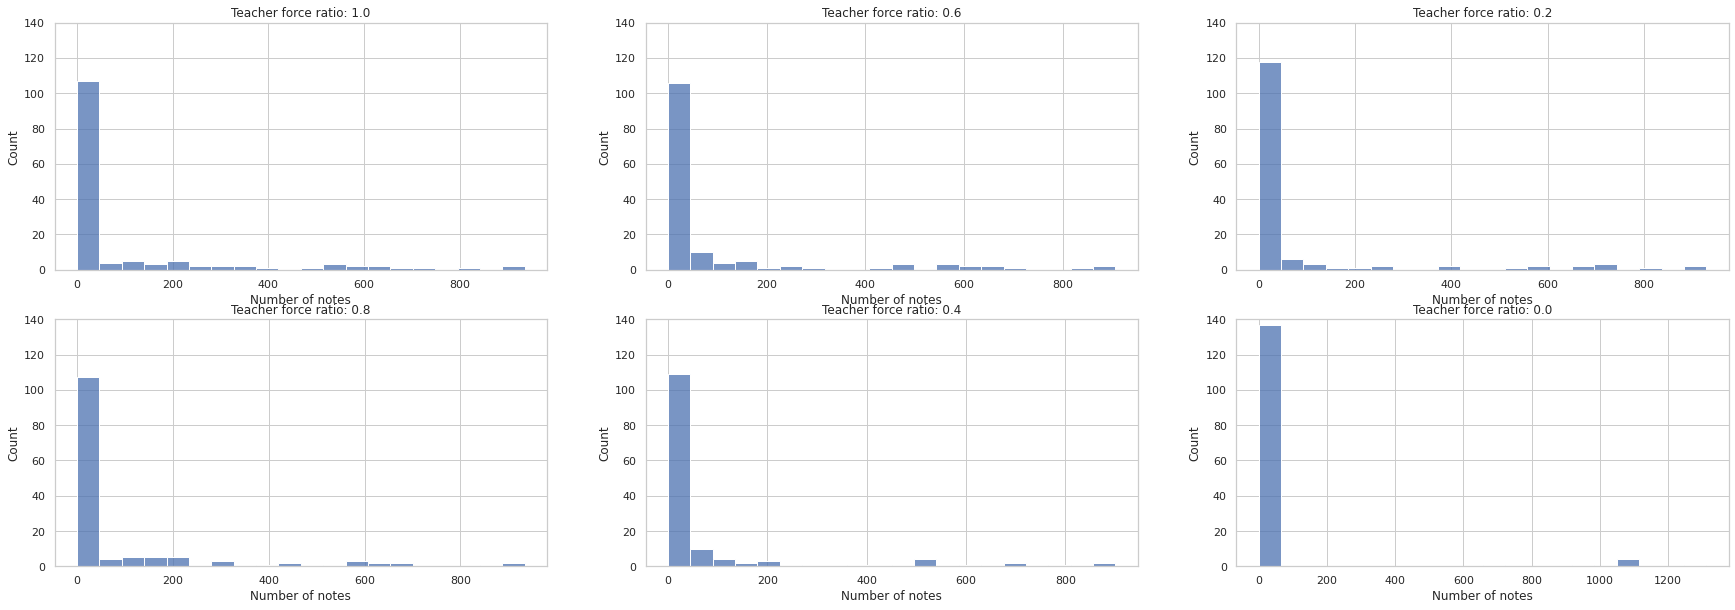

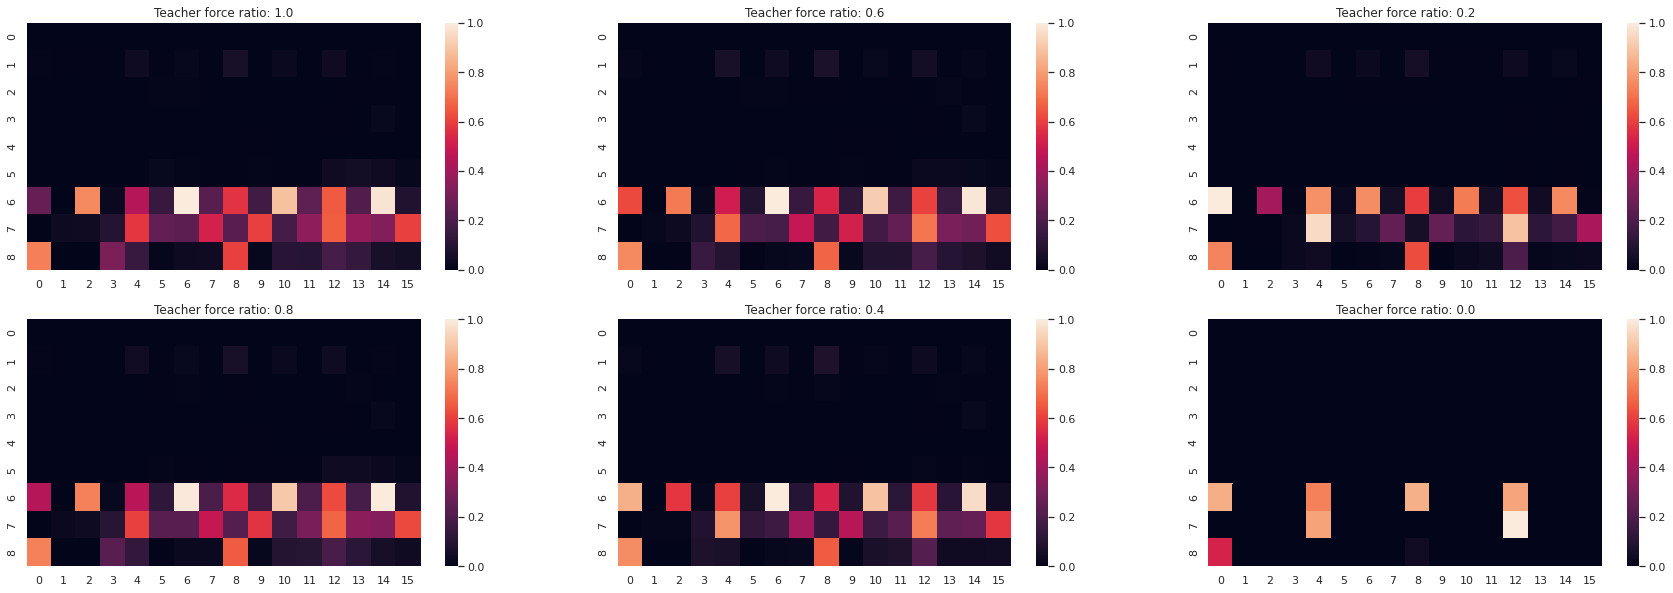

In [30]:
# plot
rows = 2
cols = 3

print(f"------------------------ ADDED NOTES ------------------------\n")
teacher_force_ratios = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
fig, axs = plt.subplots(rows, cols, figsize=(30, 10))
count = 0
for i in range(len(teacher_force_ratios) // rows):
    for j in range(len(teacher_force_ratios) // cols):
        axs[j, i].set_title(f"Teacher force ratio: {teacher_force_ratios[count]}")
        sns.histplot(output_data[teacher_force_ratios[count]]["total_added"].cpu().numpy()[0], ax=axs[j, i], bins=20, stat="count")
        count += 1
        axs[j, i].set_xlabel("Number of notes")
        axs[j, i].set_ylim([0, 140])
        # axs[j, i].set_yscale("log")
plt.show()

fig, axs = plt.subplots(rows, cols, figsize=(30, 10))
count = 0

for i in range(len(teacher_force_ratios) // rows):
    for j in range(len(teacher_force_ratios) // cols):
        axs[j, i].set_title(f"Teacher force ratio: {teacher_force_ratios[count]}")
        sns.heatmap(output_data[teacher_force_ratios[count]]["heatmap_added"], ax=axs[j, i])
        count += 1
plt.show()

#### Missing notes

------------------------ MISSING NOTES ------------------------



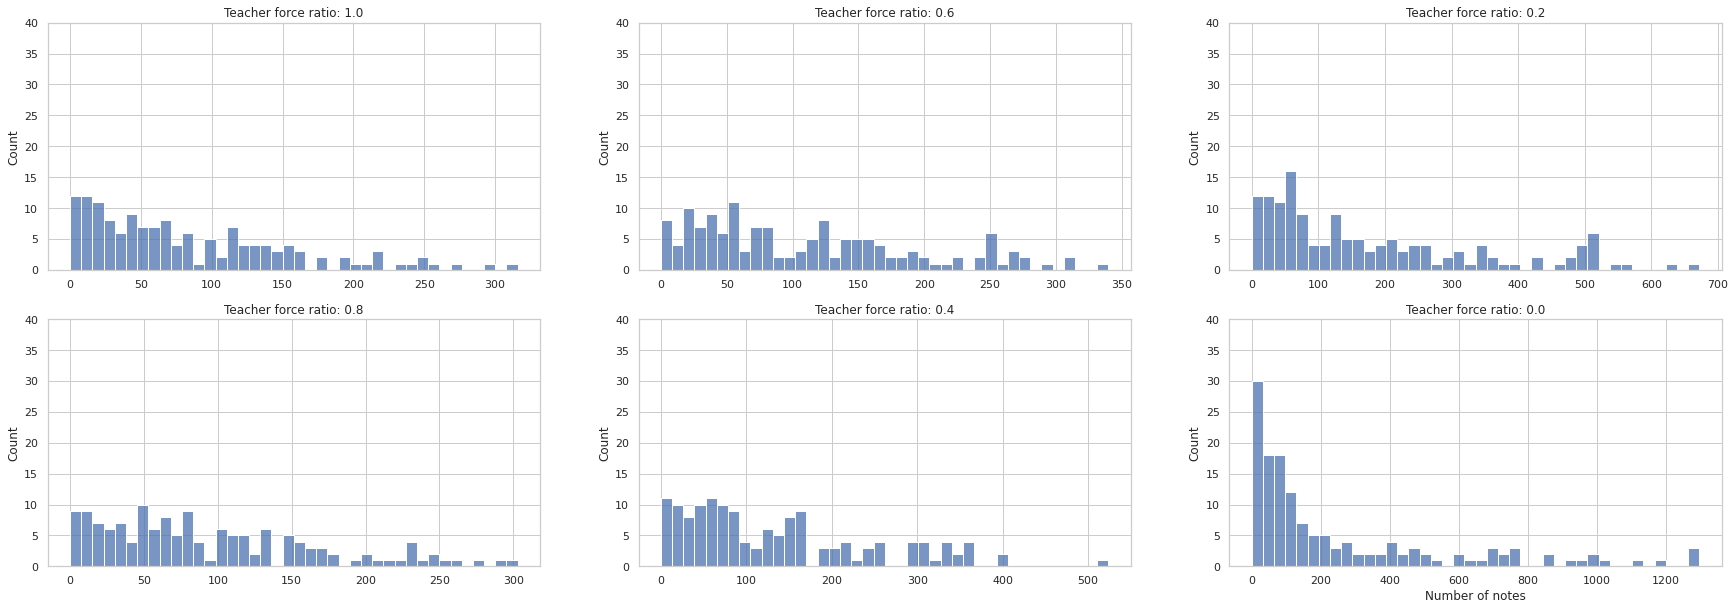

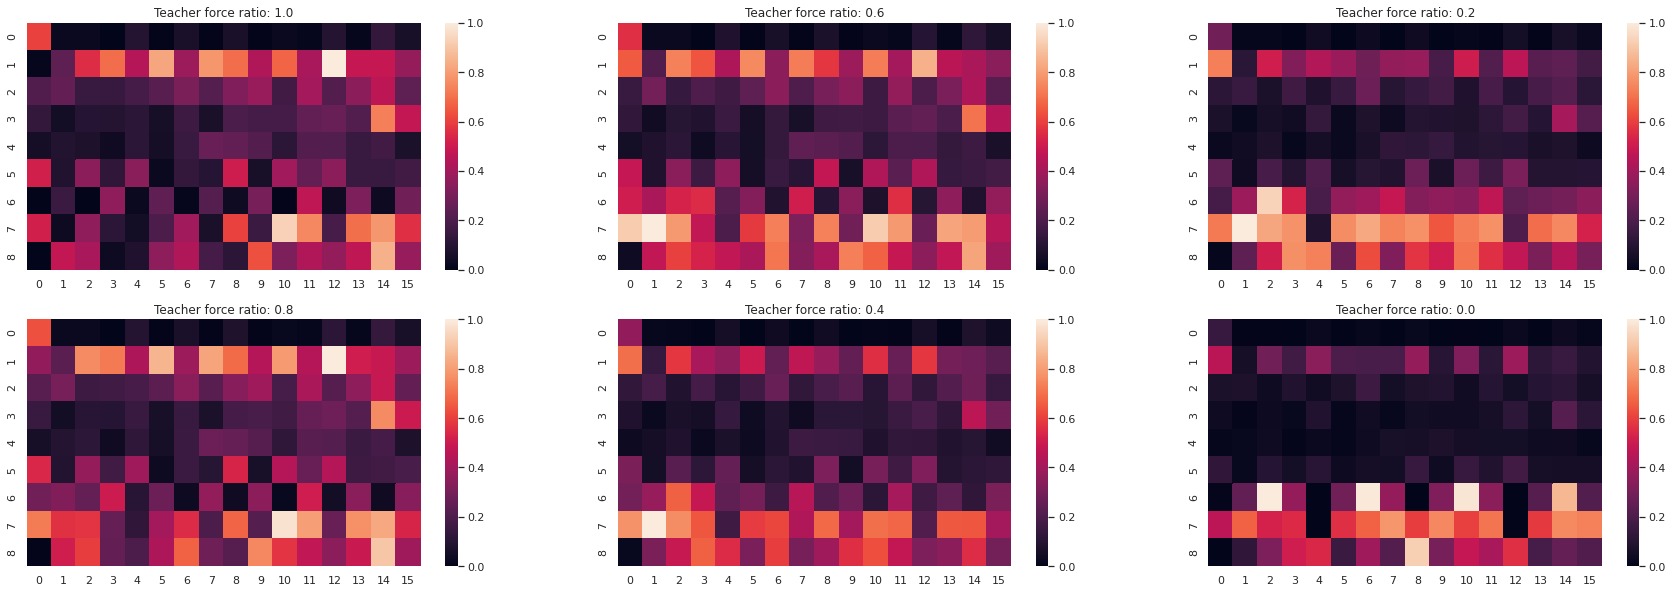

In [31]:
print(f"------------------------ MISSING NOTES ------------------------\n")
fig, axs = plt.subplots(rows, cols, figsize=(30, 10))
count = 0
for i in range(len(teacher_force_ratios) // rows):
    for j in range(len(teacher_force_ratios) // cols):
        axs[j, i].set_title(f"Teacher force ratio: {teacher_force_ratios[count]}")
        sns.histplot(output_data[teacher_force_ratios[count]]["total_missing"].cpu().numpy()[0], ax=axs[j, i], bins=40, stat="count")
        axs[j, i].set_ylim([0, 40])
        count += 1
        plt.xlabel("Number of notes")
plt.show()

fig, axs = plt.subplots(rows, cols, figsize=(30, 10))
count = 0

for i in range(len(teacher_force_ratios) // rows):
    for j in range(len(teacher_force_ratios) // cols):
        axs[j, i].set_title(f"Teacher force ratio: {teacher_force_ratios[count]}")
        sns.heatmap(output_data[teacher_force_ratios[count]]["heatmap_missing"], ax=axs[j, i])
        count += 1
plt.show()


#### Average number of notes anomalies per ratio

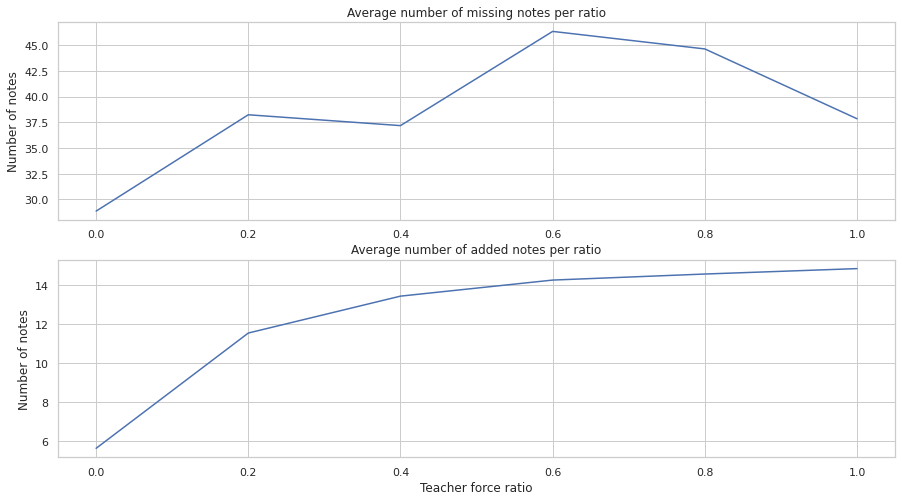

In [27]:
average_missing = []
average_added = []
for i in range(len(teacher_force_ratios)):
    tensor = output_data[teacher_force_ratios[i]]["heatmap_missing"]
    average_missing.append(torch.sum(tensor).item())
    
    tensor = output_data[teacher_force_ratios[i]]["heatmap_added"]
    average_added.append(torch.sum(tensor).item())
    
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].set_title("Average number of missing notes per ratio")
axs[0].plot(teacher_force_ratios, average_missing)
axs[1].set_xlabel("Teacher force ratio")
axs[0].set_ylabel("Number of notes")

axs[1].plot(teacher_force_ratios, average_added)
axs[1].set_title("Average number of added notes per ratio")
axs[1].set_ylabel("Number of notes")
axs[1].set_xlabel("Teacher force ratio")
plt.show()

### Pattern density

In [3]:
logger = get_logger()
config = Config(device="cpu", parse=False)
config.loss_params(epoch=0)
config.batch_size = 1
config.index_input = False

loader, config = load_dataset(config)
CHANNELS = config.input_shape[-1]
NOTE_DROPOUT = torch.tensor(0., device="cpu")
config.note_dropout = NOTE_DROPOUT

models = {}

cpu_model = RNNVAE(config)
cuda_model = RNNVAE(config)
cpu_model.load_state_dict(torch.load(MODEL_PATH))
cuda_model.load_state_dict(torch.load(MODEL_PATH))
models['pt_cpu'] = cpu_model.cpu()
models['pt_cpu'].eval()
models['pt_cuda'] = cuda_model.cuda()
models['pt_cuda'].eval()

2020-11-08 21:10:22,768 - DEBUG - new config: device=cpu
2020-11-08 21:10:22,771 - INFO - optimization will be on cpu
2020-11-08 21:10:22,867 - DEBUG - Loading files for gmd
2020-11-08 21:10:22,890 - INFO - Using input shape: (32, 27)
2020-11-08 21:10:22,976 - DEBUG - Loading files for gmd
2020-11-08 21:10:22,997 - INFO - Using input shape: (32, 27)
/home/max/.local/virtualenv/sgroove/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RNNVAE(
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (encoder): RNNEncoder(
    (embedding_dropout): Dropout(p=0.3, inplace=False)
    (_rnn): GRU(27, 512, num_layers=2, dropout=0.2)
  )
  (decoder): RNNDecoder(
    (embedding_dropout): Dropout(p=0.3, inplace=False)
    (_rnn): GRU(27, 512, dropout=0.2)
  )
  (mu): Linear(in_features=1024, out_features=2, bias=True)
  (logvar): Linear(in_features=1024, out_features=2, bias=True)
  (from_latent): Linear(in_features=2, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=27, bias=True)
  (onsets_act): Sigmoid()
  (velocities_act): Sigmoid()
  (offsets_act): Tanh()
)

In [4]:
# onnx
onnx_model_loaded = False

try:
    models['onnx_cpu'] = onnx.load(ONNX_CPU_MODEL_PATH)
    onnx.checker.check_model(models['onnx_cpu'])
    onnx_model_loaded = True
except FileNotFoundError as e:
    print(e)
    pass

## Data

In [5]:
# load one-hot sample
batch_size = 5
inputs = []

for i in range(batch_size):
    inputs.append(sample(1, config, volume="valid"))

2020-11-08 21:10:29,228 - DEBUG - Loading files for gmd
2020-11-08 21:10:29,249 - INFO - Using input shape: (32, 27)
2020-11-08 21:10:29,328 - DEBUG - Loading files for gmd
2020-11-08 21:10:29,348 - INFO - Using input shape: (32, 27)
2020-11-08 21:10:29,427 - DEBUG - Loading files for gmd
2020-11-08 21:10:29,446 - INFO - Using input shape: (32, 27)
2020-11-08 21:10:29,525 - DEBUG - Loading files for gmd
2020-11-08 21:10:29,545 - INFO - Using input shape: (32, 27)
2020-11-08 21:10:29,625 - DEBUG - Loading files for gmd
2020-11-08 21:10:29,645 - INFO - Using input shape: (32, 27)


## Regression tests

1. Check consistency across models and input with note_dropout=0

If ONNX models pass the test, we will exclusively use them for evaluation from now.

In [6]:
# functions
def assert_equal(a, b):
    if torch.all(a.eq(b)):
        pass
    else:
        raise ValueError
        
def to_numpy(tensor):
    return (
        tensor.detach().cpu().numpy()
        if tensor.requires_grad
        else tensor.cpu().numpy()
    )

def reconstruction_loss(onsets, velocities, offsets, target):
    target = torch.transpose(target, 0, 1).float()
    target_onsets, target_velocities, target_offsets = torch.split(target, onsets.shape[-1], dim=-1)
    onsets_loss = F.binary_cross_entropy(onsets, target_onsets, reduction="mean")
    velocities_loss = F.mse_loss(velocities, target_velocities, reduction="mean")
    offsets_loss = F.mse_loss(offsets, target_offsets, reduction="mean")
    return onsets_loss + velocities_loss + offsets_loss

In [7]:
r_loss = 0 
error_count = 0
success_count = 0

for batch in inputs:
    # CPU
    with torch.no_grad():
        x = batch[0].to(config.device, non_blocking=True)
        delta_z = torch.tensor([0.0, 0.0], dtype=torch.float)
        target = batch[1].to(config.device, non_blocking=True)
        outputs = models['pt_cpu'](x, torch.tensor([0., 0.]), NOTE_DROPOUT)
    
    onsets = outputs[0].clone().detach()
    velocities = outputs[1].clone().detach()
    offsets = outputs[2].clone().detach()
    result = torch.where(onsets > 0.5, torch.tensor(1.), torch.tensor(0.))
    loss = reconstruction_loss(onsets, velocities, offsets, target.unsqueeze(0))
    r_loss += loss.detach().item() / 2

r_loss /= len(inputs)
print(f'PyTorch model passed input-output equality tests. \naverage r_loss = {r_loss}')

PyTorch model passed input-output equality tests. 
average r_loss = 0.0682616364210844


In [8]:
if onnx_model_loaded:
    error_count = 0
    success_count = 0

    for s in inputs:
        # CPU
        ort_session = onnxruntime.InferenceSession(ONNX_CPU_MODEL_PATH)
        x = batch[0].to(config.device, non_blocking=True)
        delta_z = torch.tensor([0.0, 0.0], dtype=torch.float)
        target = torch.tensor(batch[1]).to(config.device, non_blocking=True)

        ort_inputs = {
            'input': to_numpy(x),
            'delta_z': np.array([0., 0.], dtype=np.float32),
            'note_dropout': NOTE_DROPOUT.unsqueeze(0).numpy()
        }
        outputs = ort_session.run(None, ort_inputs)

        onsets = torch.tensor(outputs[0])
        velocities = torch.tensor(outputs[1])
        offsets = torch.tensor(outputs[2])
        result = torch.where(onsets > 0.5, torch.tensor(1.), torch.tensor(0.))
        loss = reconstruction_loss(onsets, velocities, offsets, target.unsqueeze(0))
        r_loss += loss.detach().item() / 2

    r_loss /= len(inputs)

    print(f'ONNX model passed input-output equality tests. \nr_loss = {r_loss}')
else:
    print('Passing. ONNX model is not loaded.')

<ipython-input-8-d42518fc09d8>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(batch[1]).to(config.device, non_blocking=True)


ONNX model passed input-output equality tests. 
r_loss = 0.08270364664494992


## Helper functions

#### Plot

In [9]:
def plot_sequences(sequences, group_by=2):
    """
    Plots MIDI sequences
    Args:
        sequences: List of vocab indices in a sequence
    Returns:
        None
    """
    def init_figure(n):
        dim_dict = {}
        for i in range(len(sequences)):
            dim_dict[i + 1] = [math.ceil((i + 1) / 2), group_by]
        x = 16
        y = 2
        dims = dim_dict[n]
        fig = plt.figure(figsize=(25, (n/2)*8))
        return fig, dims

    fig, dims = init_figure(len(sequences))

    for i, seq in enumerate(sequences):
        i += 1
        fig.add_subplot(dims[0], dims[1], i)
        plt.imshow(torch.transpose(seq, 0, 1).numpy(), cmap="hot")
        if i == 1:
            plt.title("Original")
        else:
            plt.title(f"Pattern {i}")
        plt.ylabel("instrument")
        plt.xlabel("step")
        plt.axis([0, 31, 0, 27])
        plt.clim(0, 1)
        plt.colorbar()
    plt.show()

TEST PLOT


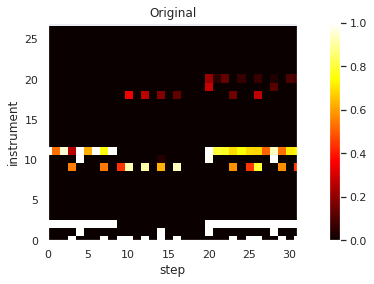

In [10]:
print('TEST PLOT')
x = inputs[3][0]
# pattern, _ = from_index(x, 512)
plot_sequences([target.squeeze()])

## Test latent space 

2020-11-08 21:11:37,571 - DEBUG - Loading files for gmd
2020-11-08 21:11:37,591 - INFO - Using input shape: (32, 27)
<ipython-input-12-dafb626ed1c3>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(s[1]).to("cpu")
<ipython-input-12-dafb626ed1c3>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(batch[1]).to(config.device, non_blocking=True)


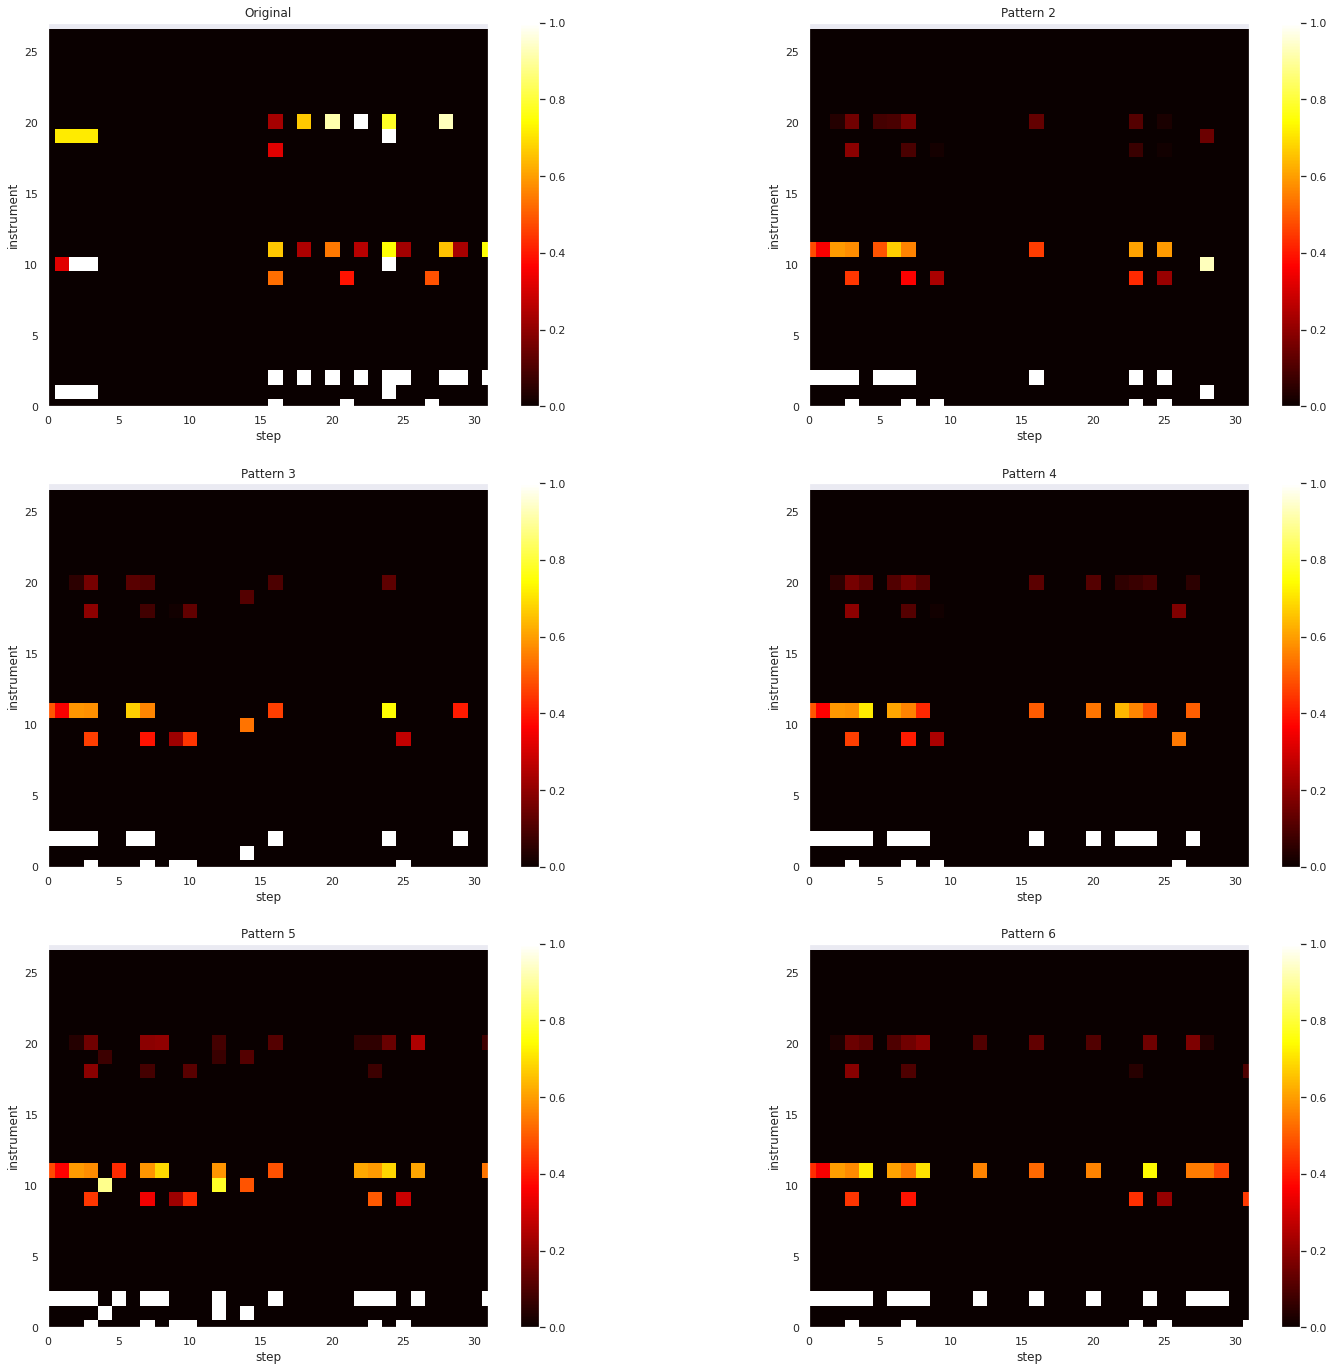

In [12]:
# config
NOTE_DROPOUT = torch.tensor(0.4)
config.note_dropout = NOTE_DROPOUT
patterns = []

# load one-hot sample
s = sample(1, config, volume="valid")
x = torch.tensor(s[1]).to("cpu")
patterns.append(x.squeeze())

for i in range(5):
    # PYTORCH
    with torch.no_grad():
        x = batch[0].to(config.device, non_blocking=True)
        delta_z = torch.tensor([0.0, 0.0], dtype=torch.float)
        target = torch.tensor(batch[1]).to(config.device, non_blocking=True)
        outputs = models['pt_cpu'](x, torch.tensor([0., 0.]), NOTE_DROPOUT)
    
    onsets = outputs[0]
    velocities = outputs[1]
    offsets = outputs[2]
    onsets = torch.where(onsets > 0.8, torch.tensor(1.), torch.tensor(0.))
    velocities = torch.where(onsets > 0.8, velocities, torch.tensor(0.))
    offsets = torch.where(onsets > 0.8, offsets, torch.tensor(0.))
    result = torch.cat([onsets, velocities, offsets], dim=-1)
    
#     # ONNX - deactivate if not yet exported
#     ort_session = onnxruntime.InferenceSession(ONNX_CUDA_MODEL_PATH)
#     ort_inputs = {
#         'input': to_numpy(x),
#         'delta_z': np.array([0., 0.], dtype=np.float32),
#         'note_dropout': NOTE_DROPOUT.unsqueeze(0).numpy()
#     }
#     outputs = ort_session.run(None, ort_inputs)
#     y = torch.sigmoid(torch.tensor(outputs[0]))
#     result = torch.where(y > 0.5, torch.tensor(1.), torch.tensor(0.))
    patterns.append(result.squeeze())
    
    
plot_sequences(patterns, 2)

## Evaluate latent variable output

First, let's see if there's any patterns in the latent space when passing in the full validation data.

The values look distributed fairy well across the space but could also be more or less random, we need a way to evaluate the output based on a range of z-values.

In [ ]:
NOTE_DROPOUT = 0.

patterns = []
z1 = []
z2 = []

st = datetime.now()
for batch in loader["valid"]:
    # input
    x = batch[0].numpy()
    delta_z = np.array([0., 0.], dtype=np.float32)
    note_dropout = np.array([NOTE_DROPOUT], dtype=np.float32)

    ort_session = onnxruntime.InferenceSession(ONNX_CPU_MODEL_PATH)
    ort_inputs = {
        'input': x,
        'delta_z': delta_z,
        'note_dropout': note_dropout
    }
    outputs = ort_session.run(None, ort_inputs)
        
    # gather output
    y = torch.sigmoid(torch.tensor(outputs[0]))
    result = torch.where(y > 0.5, torch.tensor(1.), torch.tensor(0.))
    z1.append(outputs[1][0][0])
    z2.append(outputs[1][0][1])
    patterns.append(result.squeeze())

# run and clock
delta_t = (datetime.now() - st)
print('CPU: ', delta_t)

In [ ]:
outputs[0].shape

In [ ]:
# plot
x = np.array(z1)
y = np.array(z2)

f, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=80, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

In [ ]:
horst

### Feedback mode

In [ ]:
# config
NOTE_DROPOUT = torch.tensor(0.3)
config.note_dropout = NOTE_DROPOUT
patterns = []

# load one-hot sample
s = sample(1, config, volume="valid")
x = s[0].to("cpu")
input_pattern = x
patterns.append(torch.transpose(input_pattern, 0, 1).squeeze())

for i in range(29):
    # PYTORCH
    with torch.no_grad():
        x = s[0].to("cpu")
        mask = torch.tensor(s[1]).to("cpu")
        outputs = models['pt_cpu'](x, mask, torch.tensor([0., 0.]), NOTE_DROPOUT)
    
    y = torch.sigmoid(outputs[0])
    output_pattern = torch.where(y > 0.5, torch.tensor(1.), torch.tensor(0.))
    
    # ONNX - deactivate if not yet exported
    ort_session = onnxruntime.InferenceSession(ONNX_CUDA_MODEL_PATH)
    ort_inputs = {
        'input': to_numpy(x),
        'delta_z': np.array([0., 0.], dtype=np.float32),
        'note_dropout': NOTE_DROPOUT.unsqueeze(0).numpy()
    }
    outputs = ort_session.run(None, ort_inputs)
    y = torch.sigmoid(torch.tensor(outputs[0]))
    result = torch.where(y > 0.5, torch.tensor(1.), torch.tensor(0.))
    patterns.append(result.squeeze())
    x = result;
    
    
plot_sequences(patterns, 3)

## Rhythm Similarity Evaluation

We will use the code in the GrooveToolbox presented in ISMIR 2020 to evaluate the similarity of outputs.

## Conditional with Z-manipulation

Let's see if we can control the z-output

In [ ]:
print('TEST PLOTS')
x = cpu_inputs[2]
pattern, _ = from_index(x, 512)
plot_sequences([pattern, pattern])

In [ ]:
# load one-hot sample
# batch_size = 1
# x = sample(batch_size, config).to(config.device).long()
# x = torch.transpose(x, 0, 1)

In [ ]:
print(CHANNELS)

In [ ]:
# forward
delta_z = torch.tensor([0., 0.])
note_dropout = torch.tensor(0.3)

with torch.no_grad():
#     outputs, z, _, _ = models['pt_cpu'](x, delta= note_dropout=0.5)
    outputs = models['pt_cpu'](x, delta_z, note_dropout)
    index = torch.max(outputs[0], -1).indices
    # x_ = torch.transpose(x, 0, 1)
    print(f"r_loss: {outputs[2]}")

# extract patterns and resample through z-manipulation
patterns = []
from_index(one_hot, 512.0)
patterns.append(from_index(x, 2**CHANNELS)[0])

# outputs, z_output, _, _ = model(x, delta_z=z, note_dropout=0.5)
# one_hot2 = torch.max(outputs, -1).indices
delta_z = torch.tensor([0, 0], dtype=torch.float, device=x.device)

for i in np.arange(5):
    print('z-coordinates: ', delta_z)
    delta_z[0] += 0.01
    delta_z[1] += 0.01
    st = time.time()
    print('============ PYTORCH ==============')
    outputs = models['pt_cpu'](x, delta_z, note_dropout)
    print(f"{round(time.time() - st, 4)*1000.0} ms")
    indices2 = torch.max(outputs[0], -1).indices
    patterns.append(from_index(indices2, 2**CHANNELS)[0])
    
    inputs = {
            'input': to_numpy(base_pattern),
            'delta_z': delta_z.numpy(),
            'note_dropout': np.array([0.5], dtype=np.float32)
        }
    print('============ ONNX ==============')
    st = time.time()
    output = ort_session.run(None, ort_inputs)
    print(f"{round(time.time() - st, 4)*1000.0} ms")
    y = torch.max(torch.tensor(output[0]), -1).indices
    pattern, _ = from_index(y, 512)
    # patterns.append(pattern)


# plot
plot_sequences(patterns)

# export to midi
# for i in range(len(patterns)):
#     to_midi(torch.transpose(patterns[i], 0, 1), os.path.join(SAVE_DIR, f"pattern2{i}.mid"))

### Unconditional

In [ ]:
# resample
outputs, z_output, _ = model.sample(x, sample_size=1, z=z_output)
one_hot2 = torch.max(outputs, -1).indices
plot_sequences

In [ ]:
# load one-hot sample
batch_size = 1
x = sample(batch_size, config).to(config.device).long()
x = torch.transpose(x, 0, 1)

# forward
with torch.no_grad():
    outputs, z, _ = model.sample(x, batch_size)
    one_hot = torch.max(outputs, -1).indices

    x_ = torch.transpose(x, 0, 1)
    r_loss = reconstruction_loss(outputs, x_)
    print(f"r_loss: {r_loss}")

# extract patterns and resample through z-manipulation
patterns = []
patterns.append(from_one_hot(x_))
patterns.append(from_one_hot(one_hot))

outputs, z_output, _ = model.sample(x, batch_size, z=z)
one_hot2 = torch.max(outputs, -1).indices

for i in np.arange(5):
    print(z)
    z[0][0] += 0.5
    outputs, z_output, _ = model.sample(x, batch_size, z=z)
    r_loss = reconstruction_loss(outputs, x_)
    print(f"r_loss: {r_loss}")
    one_hot2 = torch.max(outputs, -1).indices
    patterns.append(from_one_hot(one_hot2))


# plot
plot_sequences(patterns)

# export to midi
for i in range(len(patterns)):
    to_midi(torch.transpose(patterns[i], 0, 1), os.path.join(SAVE_DIR, f"pattern{i}.mid"))